In [1]:
#!/usr/bin/env pythonP
# coding: utf-8

import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma
from itertools import combinations

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm

#Import packages for clustering
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod


#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed


In [2]:
def ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol, aspect_ratio=1):
    positions_ini = Fmap[0, :, :]
    
    """
    ymax = Fmap[:, 1, :].max()
    ymin = Fmap[:, 1, :].min()
    xmax = Fmap[:, 0, :].max()
    xmin = Fmap[:, 0, :].min()
    """
    ymax = 25
    ymin = -40
    xmax = -45
    xmin = -115
    
    # Create a figure with a fixed size
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as needed
    
    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    
    # Plot the initial distribution
    #ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask)
    color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')
    #ax.pcolormesh(x.ravel(), y.ravel(), mask_interpol.ravel(), cmap=colors_mask, shading='auto')
    ax.scatter(positions_ini[0, :], positions_ini[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1)
    
    # Set axis labels and title with larger font sizes
    ax.set_xlabel("Rotated Longitude", fontsize=14)
    ax.set_ylabel("Rotated Latitude", fontsize=14)
    #ax.set_title("Initial distribution of the clusters", fontsize=16)
    
    # Set limits with some padding
    ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))
    ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))
    #ax.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min()))
    #ax.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min()))
    ax.set_aspect(aspect_ratio)  # Set a specific aspect ratio
    
    # Add legend outside the plot
    """
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j],
                          markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)]
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    """
    # Main title with larger font size
    plt.title(f"{n_clusters} clusters", fontsize=24)
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    
    # Save the figure
    plt.show()
    plt.savefig(img_name, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free up memory

In [3]:
IC_resolution = 0.5
dt = 0.0025
DT = 0.01
freq = 1
geodesic = True
e = 0
n_clusters = 20
# Format the variables
formatted_e = f"{e:.2f}"
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"
# Define other necessary variables
year = 2009
season = "AMJ"
# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"
geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
K=1000
distance = 4
k_exp = 100


In [4]:
if not os.path.exists(results_directory):
    os.makedirs(results_directory)



In [ ]:
import sys, os
import numpy as np
from mpi4py import MPI      #Importing MPI
#Import packages for geodesic distences
from pyproj import Geod

# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add utils and subfunctions folders to current working path
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")

# Import function for the polar rotation
from polar_rotation import polar_rotation_rx 
# Import function to compute pairwise distances between trajectories
from trajectory_distance import integral_vec

In [5]:

Cluster_params = (
    f"geodesic_{geodesic}_"
    f"nclusters{n_clusters}_"
    f"e{e:.2f}"
)

W_params = (
    f"geodesic_{geodesic}"
)



In [6]:


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
from parallelised_functions import split3D

sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
from Interpolant import generate_land_mask_interpolator 

from from_similarity_to_eigen import from_similarity_to_eigen, from_similarity_to_eigen_W, cut_trajectories_in_W #, from_similarity_to_eigen_cut_zones

from ploters import ini_final_clusters
from ploters import gif_clusters
from ploters import ini_final_clusters_landmask
from ploters import ini_final_clusters_landmask_ini
from ploters import gif_clusters_landmask
from degrees import degree_matrix


In [7]:
print("Reading data")
#Read input data
Fmap_path = file_path+'/0_Fmap_matrix.npy'
time_path = file_path+'/0_advection_time.npy'
W_path = file_path+'/0_W_matrix.npy'

# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
#Fmap=Fmap[:,:,::100]
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)
# Load the similarity matrix
W_vec = np.load(W_path)

dataset = nc.Dataset(regrided_geo_file_path, mode='r')
#from m/s to m/day
siu = dataset.variables['vlon'][0,:,:]
land_mask_reg = dataset.variables['land_mask'][:,:]
# Access coordinates
latitude_reg = dataset.variables['regrided_rot_lat'][:]  
longitude_reg = dataset.variables['regrided_rot_lon'][:]
dataset.close()

dataset = nc.Dataset(geo_file_path, mode='r')
#from m/s to m/day
land_mask = dataset.variables['vlon'][0,:,:].mask
print("shape of land mask")
print(str(land_mask.shape))
# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]
dataset.close()


Reading data


shape of land mask
(492, 499)


In [8]:
#Import packages for geodesic distences 
from pyproj import Geod

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")

#from trajectory_distance import integral_vec
#from similarity_matrix import similarity_matrix        #Commented out since they're currently in this script
from polar_rotation import polar_rotation_rx


In [9]:
geod = Geod(ellps='WGS84')  #equivalent to +b=6356752 +a=6378137'


In [10]:
W_cut_15, Fmap_cut_15 = cut_trajectories_in_W(Fmap, W_vec,e,10,land_mask_reg,latitude_reg,longitude_reg) 
W_cut_15.shape 


The percentage of spercified elements is 0.0
Number of points inside the polygons:
105846
Finally finished generating interpolator!
(2474,) trajectories have been removed because they were too close to land or ending up too close to land


(1377, 1377)

In [11]:
IC_cut_15=Fmap_cut_15[0,:,:] 

In [12]:
IC_cut_15_rot_lat, IC_cut_15_rot_lon = polar_rotation_rx(IC_cut_15[1], IC_cut_15[0],-90) 
IC_cut_15_rot = np.asarray(np.vstack((IC_cut_15_rot_lon,IC_cut_15_rot_lat))) 

In [15]:
W_cut_15

array([[1.00000000e+03, 5.73492800e-03, 8.11314517e-03, ...,
        3.69185462e-04, 3.67644048e-04, 3.61968202e-04],
       [5.73492800e-03, 1.00000000e+03, 1.79891730e-02, ...,
        3.72258728e-04, 3.70201395e-04, 3.65042084e-04],
       [8.11314517e-03, 1.79891730e-02, 1.00000000e+03, ...,
        3.74007836e-04, 3.72085445e-04, 3.66682296e-04],
       ...,
       [3.69185462e-04, 3.72258728e-04, 3.74007836e-04, ...,
        1.00000000e+03, 1.79514182e-02, 1.80580694e-02],
       [3.67644048e-04, 3.70201395e-04, 3.72085445e-04, ...,
        1.79514182e-02, 1.00000000e+03, 1.25700162e-02],
       [3.61968202e-04, 3.65042084e-04, 3.66682296e-04, ...,
        1.80580694e-02, 1.25700162e-02, 1.00000000e+03]],
      shape=(1377, 1377))

In [13]:
plotpolar(IC_cut_15_rot)  


NameError: name 'plotpolar' is not defined

In [38]:
#Go back to the non-rotated coordinates to compute the geodesic distances
Fmap_lat,Fmap_lon = polar_rotation_rx(np.array(Fmap[:,1,:]),np.array(Fmap[:,0,:]),-90)  #Fmap[:,0,:] contains longitudes and Fmap[:,1,:] latitudes
Fmap_rot = np.stack((np.asarray(Fmap_lon),np.asarray(Fmap_lat)),axis=1)

In [42]:
Fmap_lat.mask

AttributeError: 'matrix' object has no attribute 'mask'

In [98]:

dT = timemap[-1]-timemap[0]
# Compute time differences
time_deltas = timemap[1:] - timemap[:-1]
#Loading the Geod and polar rotation are the same for each iteration, moving them outside the loop provides a massive speedup
# Define the WGS84 ellipsoid
geod = Geod(ellps='WGS84')  #equivalent to +b=6356752 +a=6378137'
#Go back to the non-rotated coordinates to compute the geodesic distances

distances =  geod.inv(Fmap_lon[1:, i], Fmap_lat[1:, i], Fmap_lon[1:, j], Fmap_lat[1:, j])[2] + geod.inv(Fmap_lon[:-1, i], Fmap_lat[:-1, i], Fmap_lon[:-1, j], Fmap_lat[:-1, j])[2]
s = 1/(np.sum((time_deltas / 2) * distances)/dT)
        

distances.reshape(-1).shape
(distances[0]*time_deltas).shape
np.sum(distances*time_deltas)

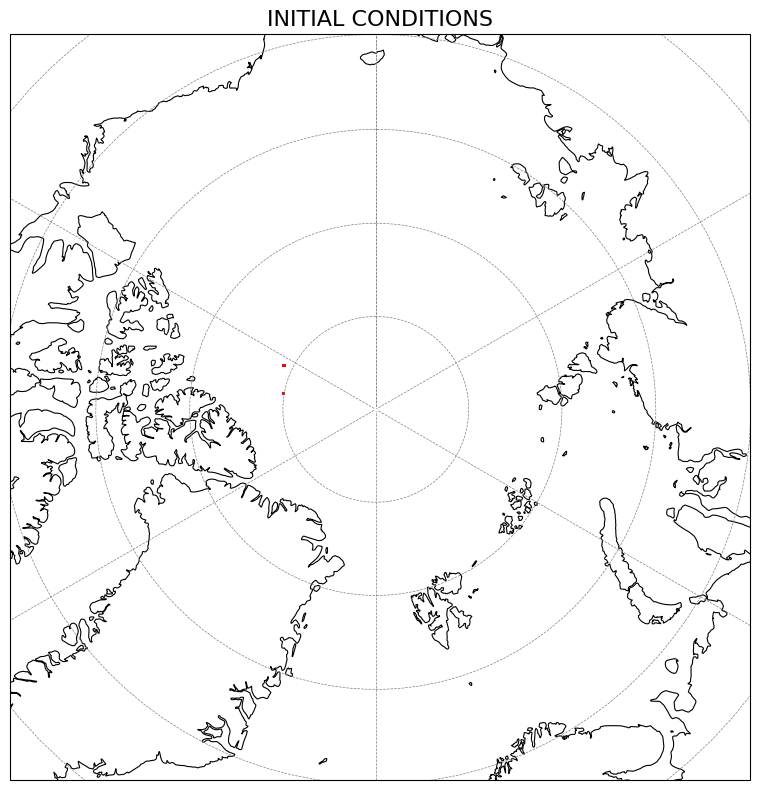

In [79]:
i=300
j=303
distances =  geod.inv(Fmap_lon[1:, i], Fmap_lat[1:, i], Fmap_lon[1:, j], Fmap_lat[1:, j])[2] + geod.inv(Fmap_lon[:-1, i], Fmap_lat[:-1, i], Fmap_lon[:-1, j], Fmap_lat[:-1, j])[2]
traji = np.asarray(np.hstack((Fmap_lon[:,i],Fmap_lat[:,i]))).T
trajj = np.asarray(np.hstack((Fmap_lon[:,j],Fmap_lat[:,j]))).T
traj=np.hstack((traji,trajj))
plotpolar(traj) 

In [78]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  



def plotpolar(IC): 
    positions_ini = IC 

    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 

    # Plot the initial cluster positions 
    ax.scatter( 
        positions_ini[0, :], positions_ini[1, :], 
        s=0.3, color="red", 
        transform=ccrs.PlateCarree()  # Specify the coordinate system of the data 
    ) 
    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree()) 
    # Add a title 
    plt.title("INITIAL CONDITIONS", fontsize=16) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.show() 
    # plt.savefig(img_name, bbox_inches='tight') 
    plt.close(fig)  # Close the figure to free up memory 


In [8]:
#l_vect,l,Fmap,n_clusters_def = from_similarity_to_eigen_cut_zones(Fmap, W_vec, e, K, k_exp, distance,land_mask_reg,latitude_reg,longitude_reg)


In [74]:
W, Fmap_cut = cut_trajectories_in_W(Fmap, W_vec,e,distance,land_mask_reg,latitude_reg,longitude_reg)
l_vect,l,Fmap,n_clusters_def = from_similarity_to_eigen_W(Fmap_cut,W,K,k_exp)

The percentage of spercified elements is 0.0
Number of points inside the polygons:
70290
Finally finished generating interpolator!
(2008,) trajectories have been removed because they were too close to land or ending up too close to land
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 100 eigenvalues
k_means clustering
The default number of clusters is 1


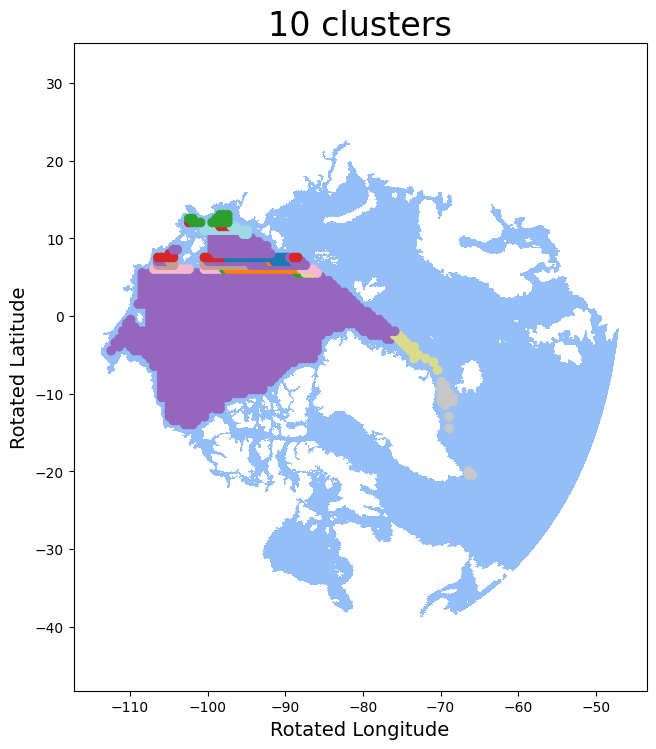

<Figure size 640x480 with 0 Axes>

In [75]:
n_clusters = 10
clf = KMeansConstrained(n_clusters,size_min=20,random_state=0,n_jobs=20)
l_vect_cut = l_vect[:,0:n_clusters]
clf.fit_predict(l_vect_cut)
labels = clf.labels_
ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)


In [76]:
Cluster_params = (
    f"geodesic_{geodesic}_"
    f"nclusters{n_clusters}_"
    f"e{e:.2f}"
)


In [77]:
n_clusters=20

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


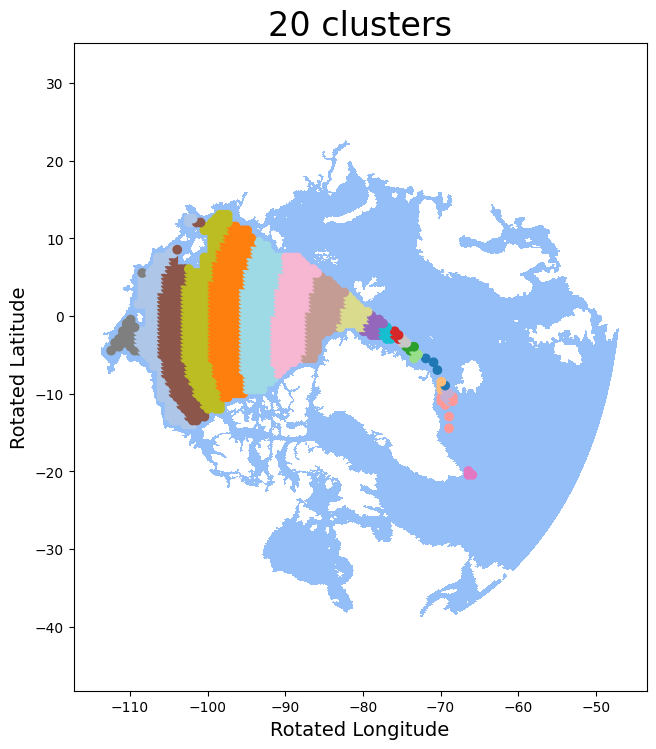

<Figure size 640x480 with 0 Axes>

In [78]:
# ### Clustering
print("Applying k-means to define the clusters")
if n_clusters==0:
    n_clusters = n_clusters_def  
l_vect_cut = l_vect[:,0:n_clusters]
kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
kmeans.fit(l_vect_cut)
labels = kmeans.labels_

np.save(results_directory+'/cut_Clusters_labels_'+Cluster_params+'.npy', labels)
#np.save(results_directory+'/cut_Fmap_'+Cluster_params+'.npy', Fmap)


print("Plotting the clusters")
#ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
#ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)



Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


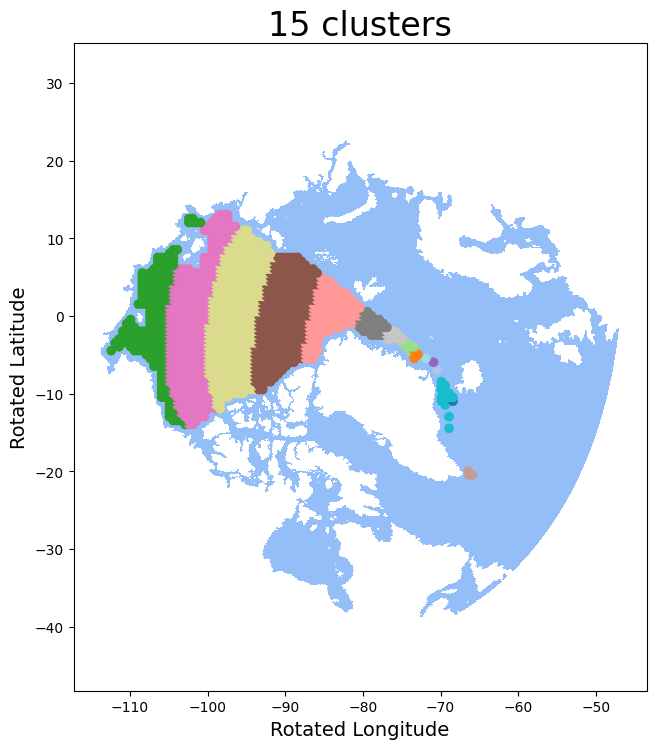

<Figure size 640x480 with 0 Axes>

In [79]:
n_clusters = 15
l_vect_cut = l_vect[:,0:14]
kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
kmeans.fit(l_vect_cut)
labels = kmeans.labels_

np.save(results_directory+'/cut_Clusters_labels_'+Cluster_params+'.npy', labels)
#np.save(results_directory+'/cut_Fmap_'+Cluster_params+'.npy', Fmap)


print("Plotting the clusters")
#ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
#ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


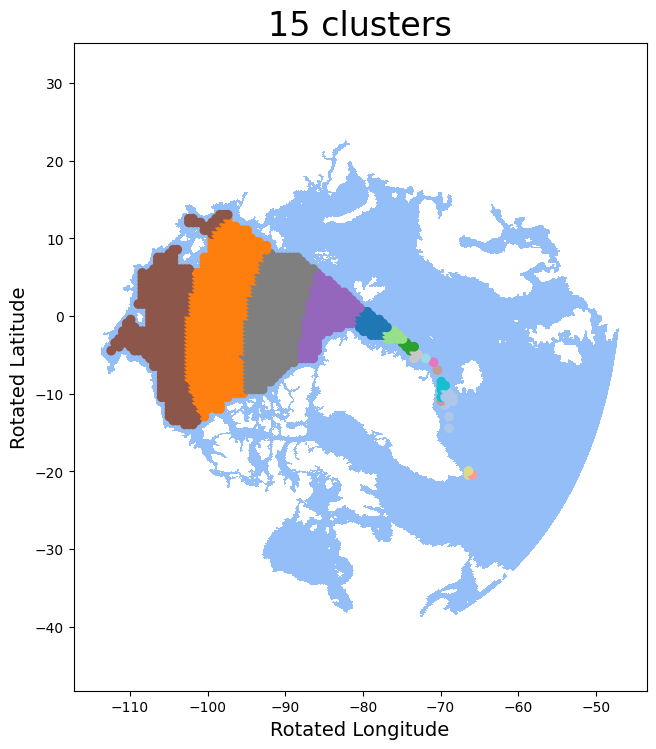

<Figure size 640x480 with 0 Axes>

In [80]:
n_clusters = 15
l_vect_cut = l_vect[:,0:15]
kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
kmeans.fit(l_vect_cut)
labels = kmeans.labels_

np.save(results_directory+'/cut_Clusters_labels_'+Cluster_params+'.npy', labels)
#np.save(results_directory+'/cut_Fmap_'+Cluster_params+'.npy', Fmap)


print("Plotting the clusters")
#ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
#ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


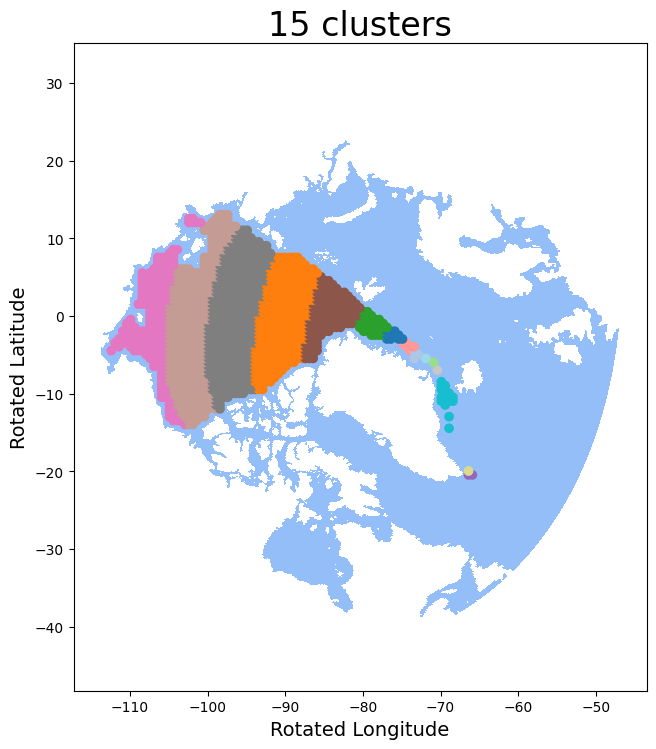

<Figure size 640x480 with 0 Axes>

In [81]:
n_clusters = 15
l_vect_cut = l_vect[:,0:n_clusters]
kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
kmeans.fit(l_vect_cut)
labels = kmeans.labels_

np.save(results_directory+'/cut_Clusters_labels_'+Cluster_params+'.npy', labels)
#np.save(results_directory+'/cut_Fmap_'+Cluster_params+'.npy', Fmap)


print("Plotting the clusters")
#ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
#ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

In [82]:
from k_means_constrained import KMeansConstrained

In [83]:
pip install --upgrade numpy


[notice] A new release of pip available: 22.2.2 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [84]:
from itertools import combinations

def cut_weight_calculator(labels):
    cluster_cut_weight = np.empty(len(set(labels)))
    ic_cut_weight = np.empty(len(labels))

    for k in set(labels):
        positions_k = [index for index, value in enumerate(labels) if value == k]
        W_tri = np.triu(W,k=1)
        pairs = combinations(positions_k, 2)  # itertools.combinations ensures i < j
        # Set matrix[i, j] to 0 for each pair
        for i, j in pairs:
            W_tri[i, j] = 0
        cluster_cut_weight[k]=np.sum(W_tri)

    for i in range(len(labels)):
        ic_cut_weight[i] = cluster_cut_weight[labels[i]]

    return ic_cut_weight


Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


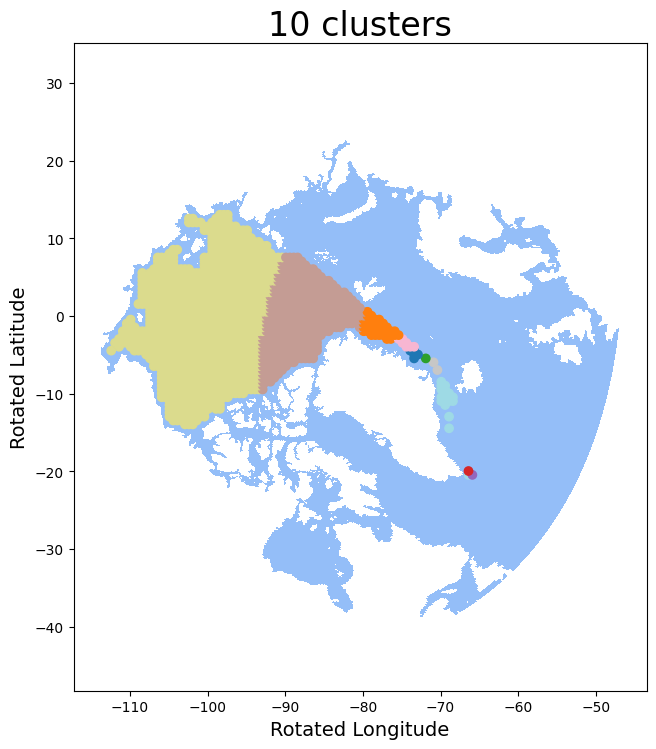

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

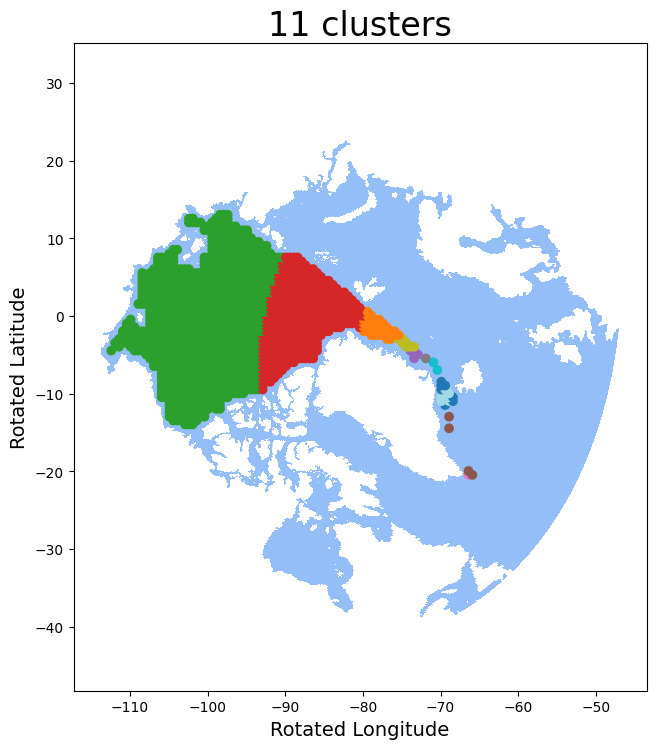

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

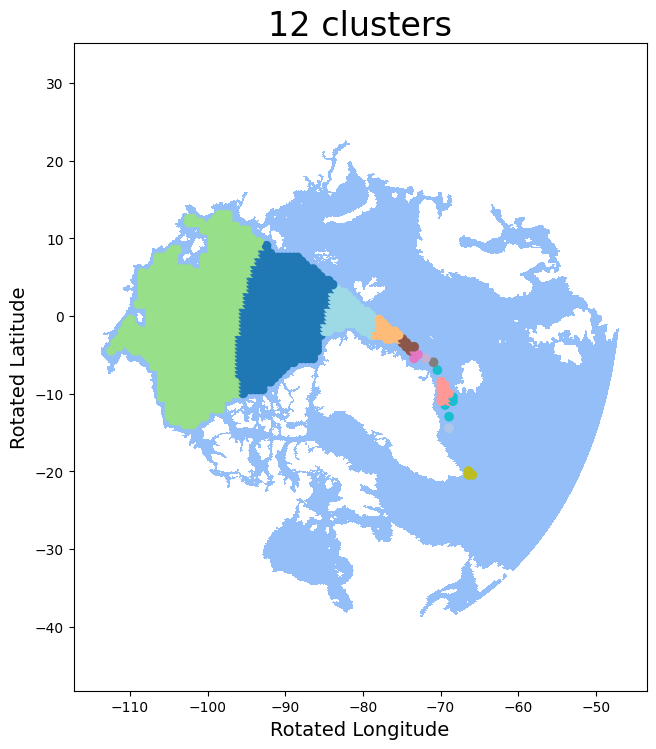

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

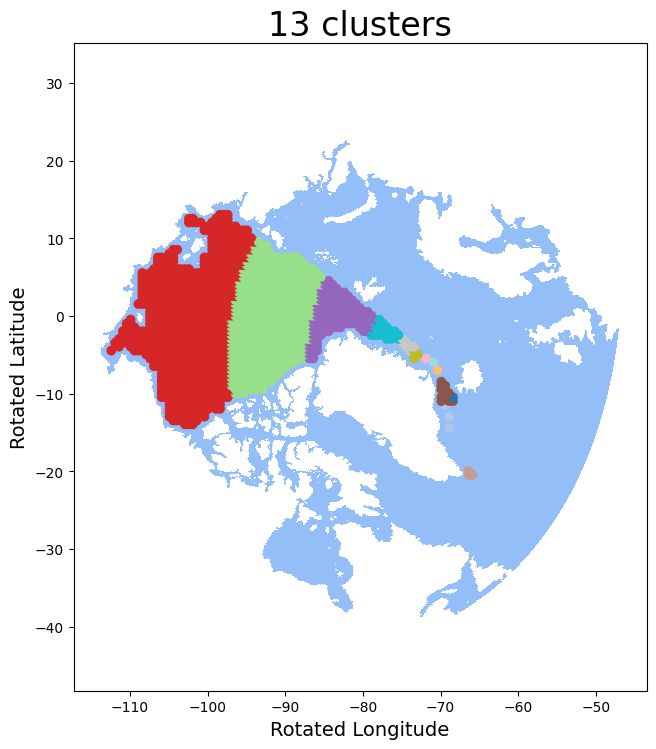

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

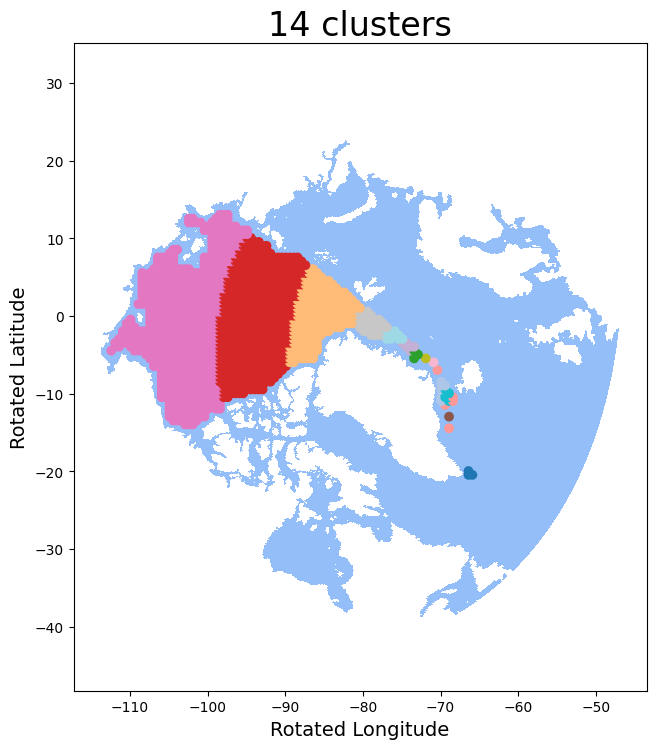

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

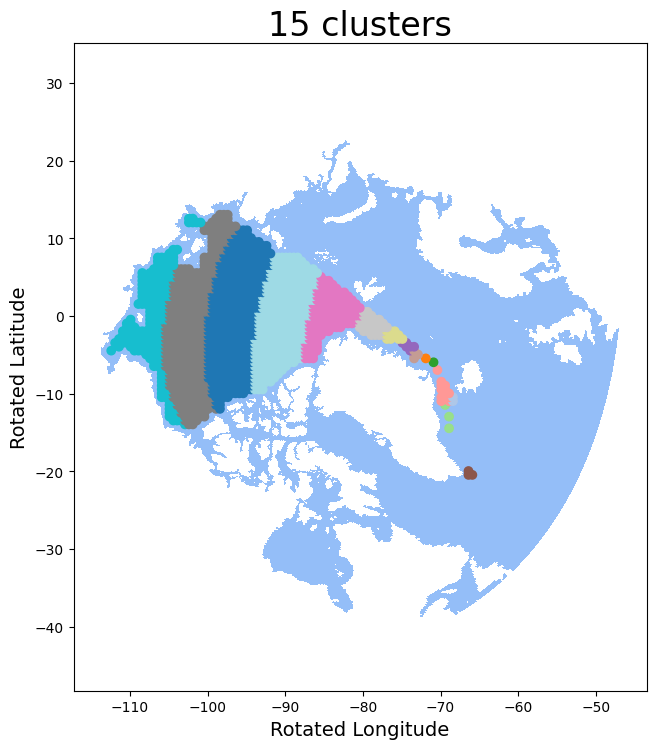

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

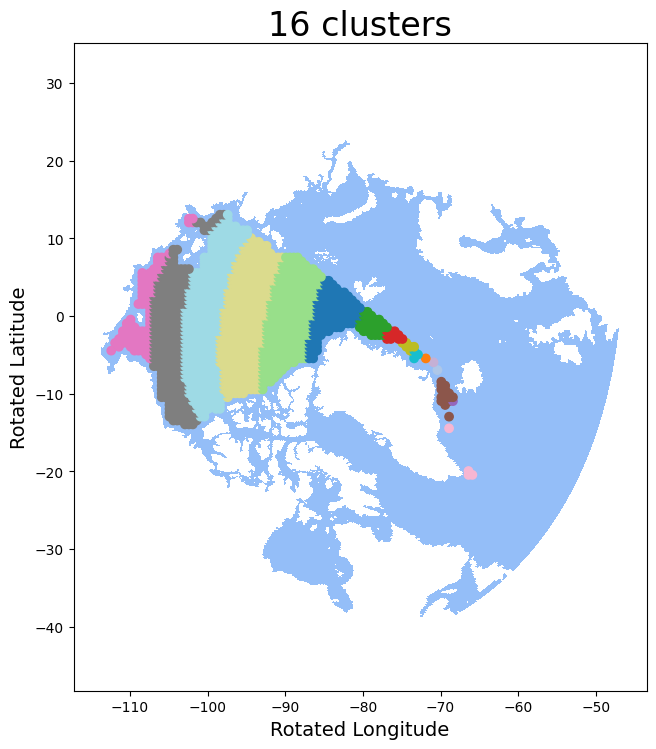

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

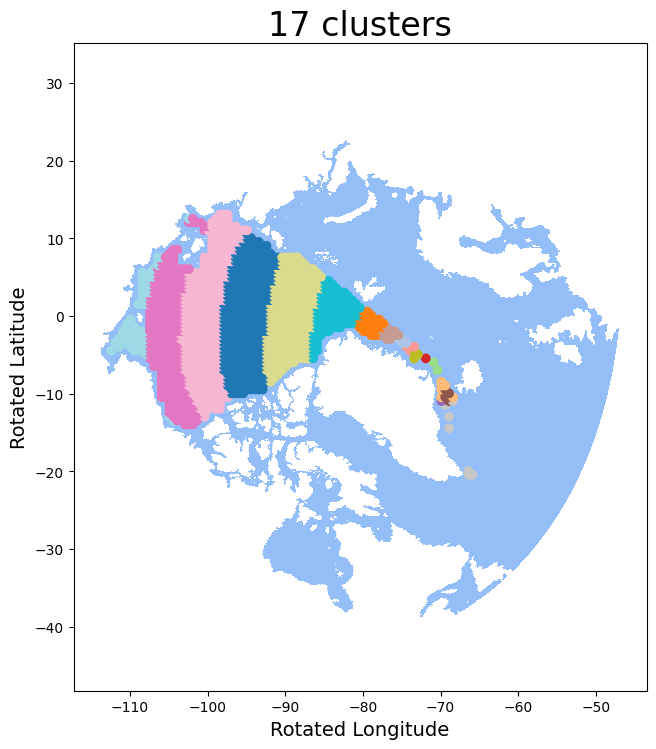

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

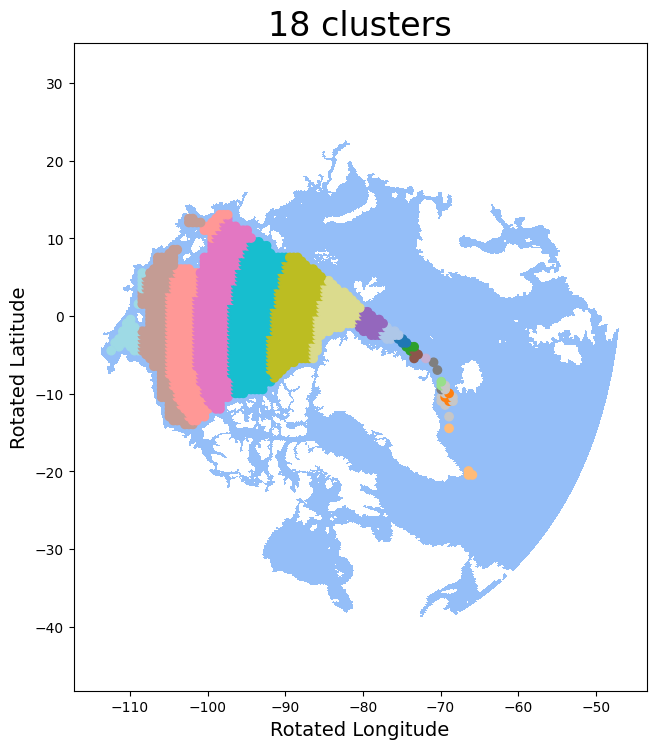

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

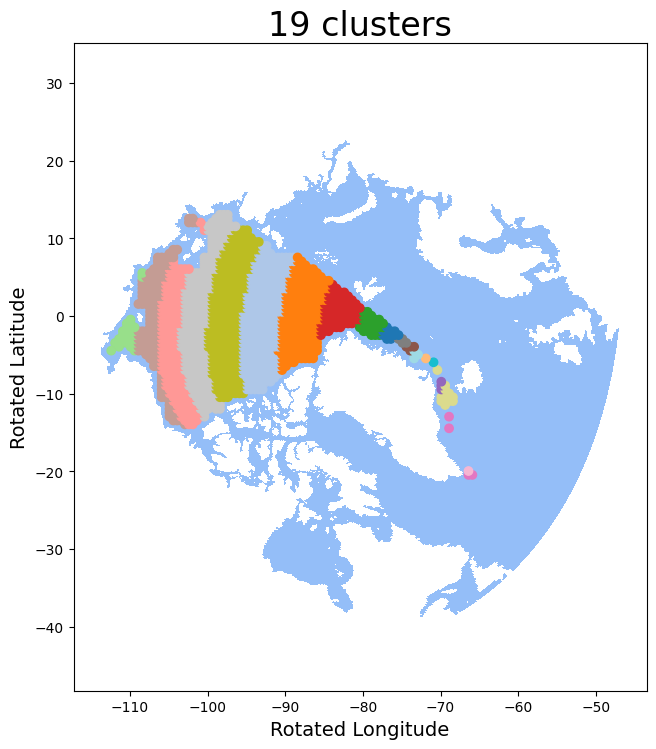

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

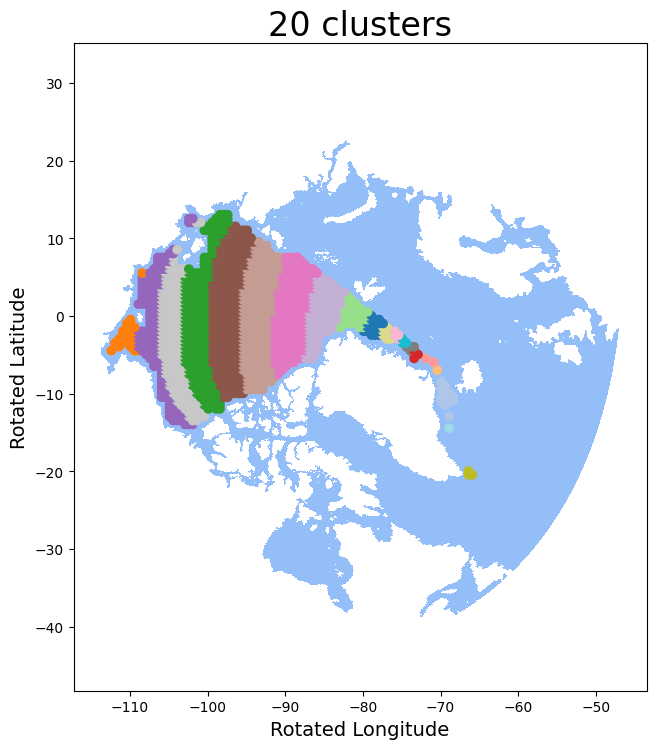

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

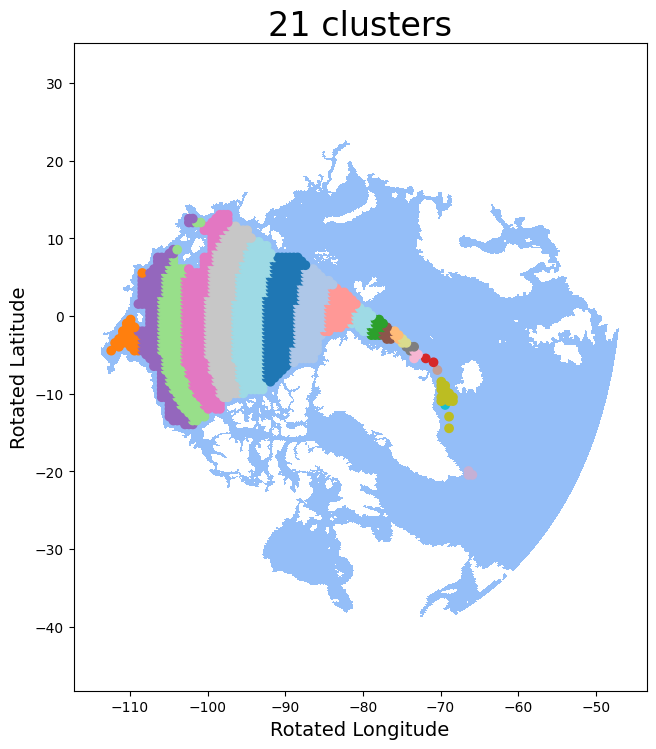

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

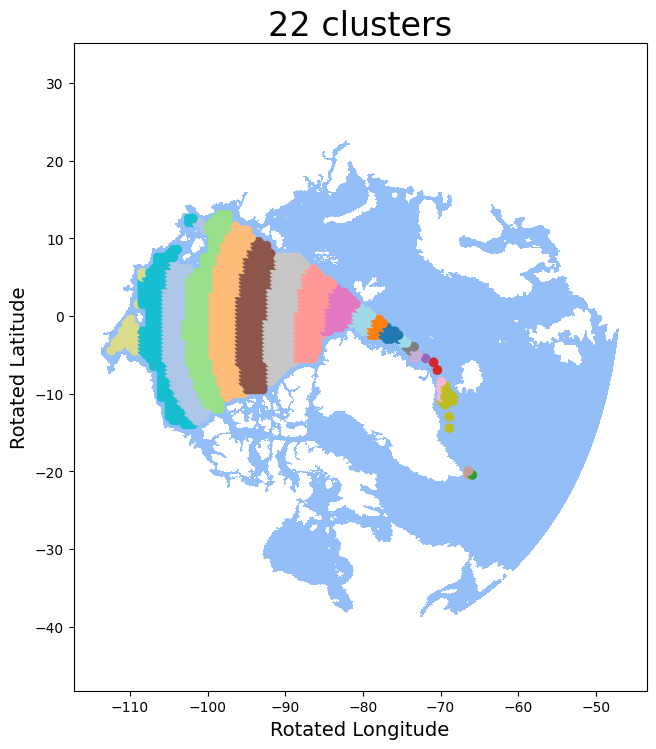

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

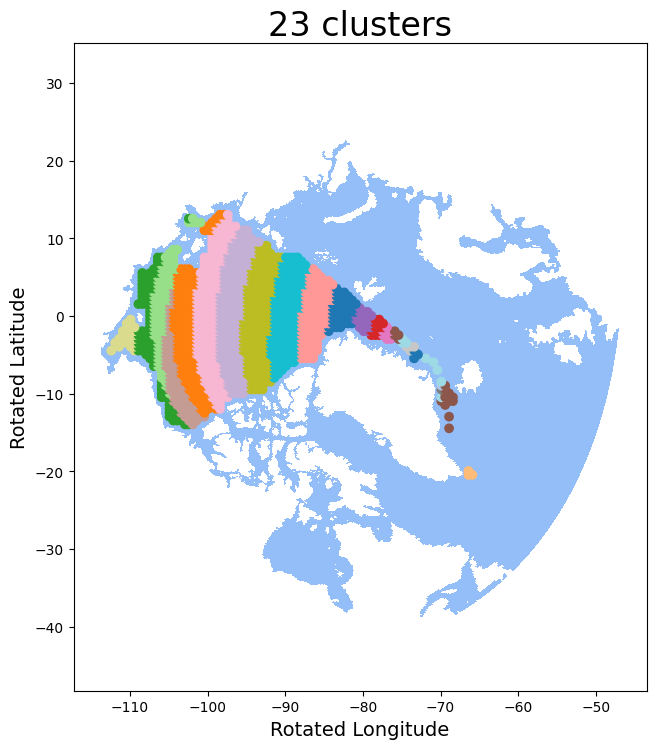

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


<Figure size 640x480 with 0 Axes>

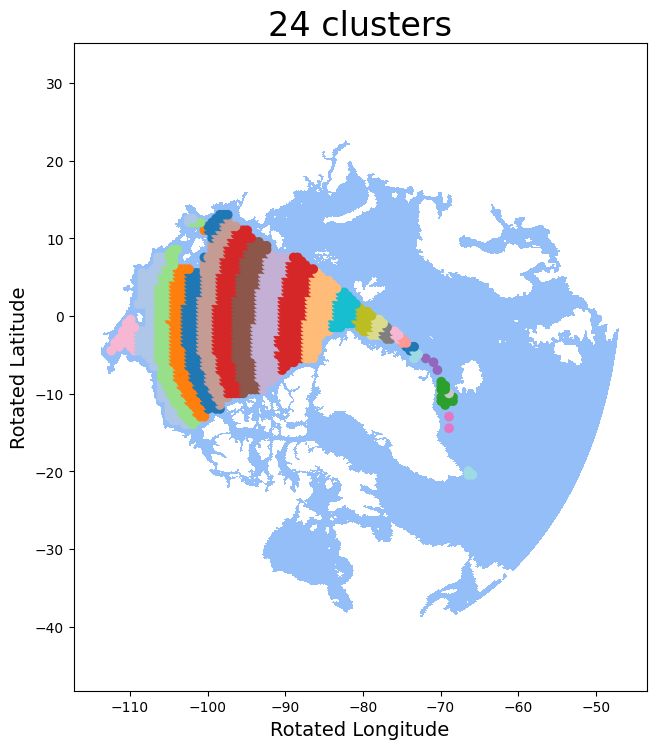

Applying k-means to define the clusters


In [ ]:
cut_weights = []
for n_clusters in range(10,30):
    Cluster_params = (
        f"geodesic_{geodesic}_"
        f"nclusters{n_clusters}_"
        f"e{e:.2f}"
    )

    # ### Clustering
    print("Applying k-means to define the clusters")
    if n_clusters==0:
        n_clusters = n_clusters_def  
    l_vect_cut = l_vect[:,0:n_clusters]
    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect_cut)
    labels = kmeans.labels_
    cut_weights.append(cut_weight_calculator(labels))

    np.save(results_directory+'/cut4_Clusters_labels_'+Cluster_params+'.npy', labels)
    np.save(results_directory+'/cut4_Fmap_'+Cluster_params+'.npy', Fmap)


    print("Plotting the clusters")
    #ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
    #ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
    ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

ic_mean_cut_weight = np.mean(cut_weights, axis=0)

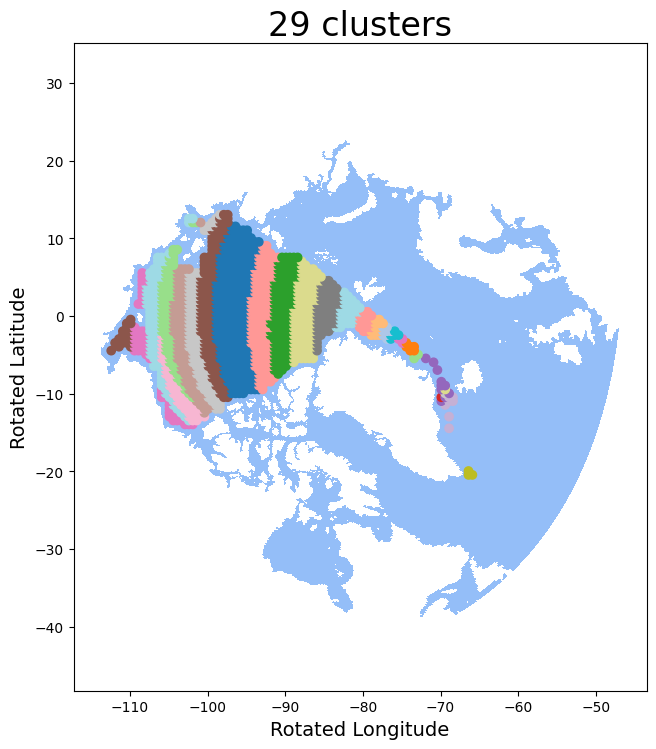

<Figure size 640x480 with 0 Axes>

In [58]:
ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

In [59]:
def ini_weights_landmask_ini(Fmap, n_clusters_min, n_clusters_max, cut, img_name, e, x, y, mask_interpol, aspect_ratio=1):
    positions_ini = Fmap[0, :, :]
    
    """
    ymax = Fmap[:, 1, :].max()
    ymin = Fmap[:, 1, :].min()
    xmax = Fmap[:, 0, :].max()
    xmin = Fmap[:, 0, :].min()
    """

    ymax = 25
    ymin = -40
    xmax = -45
    xmin = -115
    # Create a figure with a fixed size
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as needed
    
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    
    # Plot the initial distribution
    color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')
    scatter = ax.scatter(positions_ini[0, :], positions_ini[1, :], c=cut, cmap="binary")
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
    cbar.set_label("Cut cost ($deg^{-1}$)", fontsize=12)
    
    # Set axis labels and title with larger font sizes
    ax.set_xlabel("Rotated Longitude", fontsize=14)
    ax.set_ylabel("Rotated Latitude", fontsize=14)
    #ax.set_title("Initial distribution of the clusters", fontsize=16)
    
    # Set limits with some padding
    ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))
    ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))
    #ax.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min()))
    #ax.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min()))
    ax.set_aspect(aspect_ratio)  # Set a specific aspect ratio
    
    # Add legend outside the plot
    """
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j],
                          markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)]
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    """
    # Main title with larger font size
    plt.title(f"{n_clusters_min} to {n_clusters_max} clusters", fontsize=24)
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    
    # Save the figure
    plt.show()
    plt.savefig(img_name, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free up memory

/tmp/ipykernel_1944759/2308662473.py:24: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


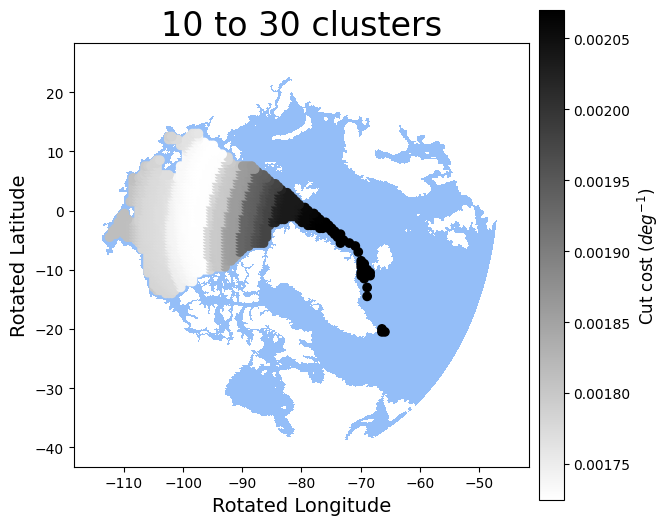

<Figure size 640x480 with 0 Axes>

In [ ]:
ini_weights_landmask_ini(Fmap, 10,30, ic_mean_cut_weight, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

Applying k-means to define the clusters
Plotting the clusters


/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/utils/ploters.py:105: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


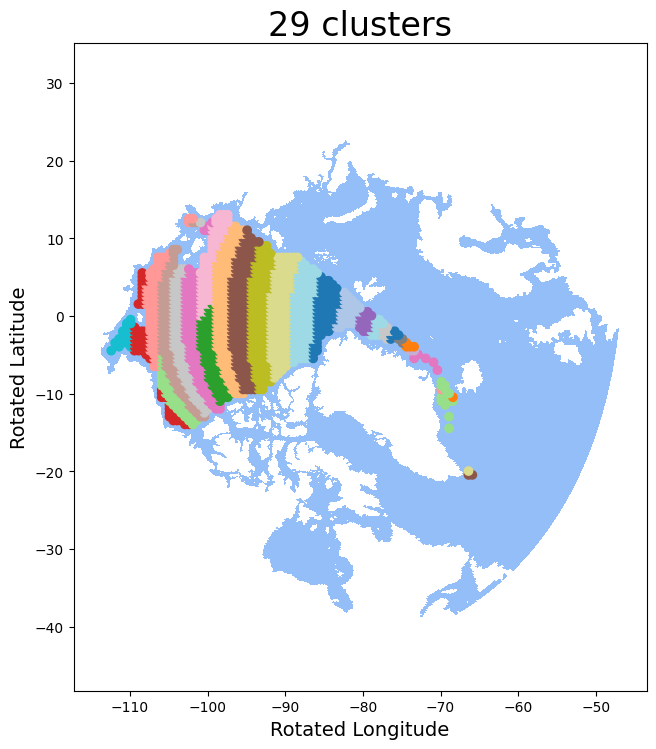

<Figure size 640x480 with 0 Axes>

In [61]:
cut_weights = []
for n_clusters in range(29,30):
    Cluster_params = (
        f"geodesic_{geodesic}_"
        f"nclusters{n_clusters}_"
        f"e{e:.2f}"
    )

    # ### Clustering
    print("Applying k-means to define the clusters")
    if n_clusters==0:
        n_clusters = n_clusters_def  
    l_vect_cut = l_vect[:,0:n_clusters]
    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect_cut)
    labels = kmeans.labels_
    cut_weights.append(cut_weight_calculator(labels))

    np.save(results_directory+'/cut4_Clusters_labels_'+Cluster_params+'.npy', labels)
    np.save(results_directory+'/cut4_Fmap_'+Cluster_params+'.npy', Fmap)


    print("Plotting the clusters")
    #ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
    #ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
    ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

ic_mean_cut_weight = np.mean(cut_weights, axis=0)

/tmp/ipykernel_1944759/2308662473.py:24: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  color_mesh = ax.pcolor(x, y, mask_interpol, cmap=colors_mask, shading='auto')


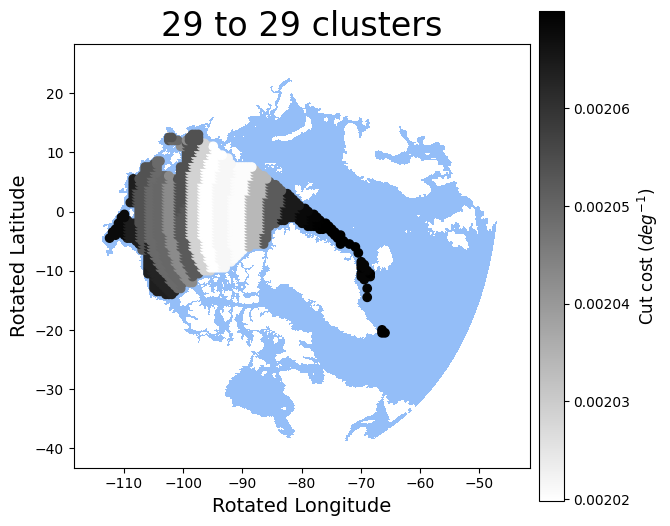

<Figure size 640x480 with 0 Axes>

In [62]:
ini_weights_landmask_ini(Fmap, 29,29, ic_mean_cut_weight, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)

In [179]:
d = [1,2,3]

In [180]:
d.shape

AttributeError: 'list' object has no attribute 'shape'

In [183]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([1, 2, 3, 4, 5])

In [184]:
a*b

array([ 1,  4,  9, 16, 25])